In [1]:
import jax
import jax.numpy as jnp
from jax.scipy.optimize import minimize
from jax.scipy.special import logsumexp
import numpy as np
import mcmc_infinity as mc
import emcee
import corner

import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'

seed = 12345

# Problem

Here we try to find the number of pulse signals in time-series data. The pulses are given by

$$ f(t) = a \exp\left(-\frac{(t - b)^2}{2 c^2}\right), $$

where $a,\,b,\, c$ are the unknown parameters of each pulse.

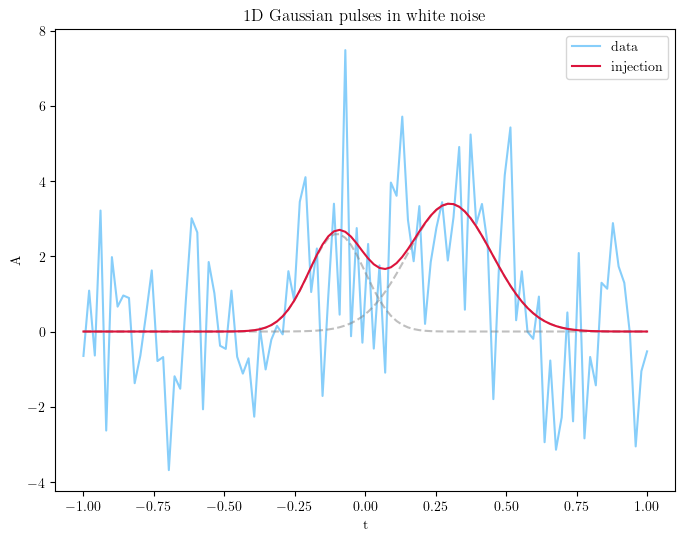

In [2]:
t, y, sigma, p_inj = mc.test_functions.multiple_pulses.gen_data()

In [3]:
dim = 3
target = mc.test_functions.multiple_pulses.llh_pulses(t, y, sigma=sigma, dim=dim)

# Uniform Proposal

Create a uniform proposal distribution with the prior bounds for each pulse.

In [4]:
bounds = np.array([[2.5, 3.], [t.min(), t.max()], [0.01, 0.21]])
kbounds = np.array([1, 5])

uniform_proposal = mc.uniform_proposal_transd.UniformProposalTransD(dim, bounds, kbounds)

Create two starting points, same k for now.

In [5]:
starting_pos = np.repeat(np.array(p_inj)[np.newaxis, :, :], 2, axis=0)

for i in range(starting_pos.shape[0]):
    for r in range(starting_pos.shape[1]):
        starting_pos[i, r] += np.random.multivariate_normal(np.zeros( starting_pos.shape[2] ), 1e-2*np.eye(starting_pos.shape[2]))

Initialise the perfect sampler.

In [6]:
sampler_uniform = mc.sampler.PerfectSampler(target, 
                                            uniform_proposal, 
                                            np.array(starting_pos), 
                                            seed=seed,
                                            rj=True,
                                            kmax=kbounds[1])

Run the perfect sampler. This will be quite slow because the uniform proposal is inefficient; we will explore more efficient KDE proposals below.

In [7]:
T = 2

num_samples = 100

samples_uniform, T_uniform = sampler_uniform.get_perfect_samples(T, 
                                                                num_samples, 
                                                                return_T=True)

  0%|          | 0/100 [00:00<?, ?it/s]

We also run a normal reversible-jump MCMC using this proposal just to check the acceptance probability.

In [ ]:
# empty for now